In [82]:
#import os
#os.environ['PYSYN_CDBS'] = "C:/Users/tchawla/research/HST_data/grp/redcat/trds"
#env_var = os.environ['PYSYN_CDBS']
#env_var
import numpy as np
from astropy.io import ascii
from pylab import *
from astropy.table import Table, vstack
import pandas as pd
from expecto import get_spectrum
from scipy.interpolate import RegularGridInterpolator as rgi
from itertools import product
%run Interpolate_final.ipynb
%run GetSpectra_final.ipynb
%run Binning_final.ipynb
%run AddNoise_final.ipynb
#%set_env PYSYN_CDBS = C:/Users/tchawla/research/HST_data/grp/redcat/trds

In [68]:
water_array = [1.0, 1.5, 2.5, 3.5, 5.0]

'''
reads in .dat files. col1 is wavelength, col2 is transmission. Files are labeled with water content level in mm 
water content levels are listed in the array above. resolution is 200,000.
'''

d = {}
i=0
for n in water_array:
    water_content = str(water_array[i])
    d["data"+water_content] = ascii.read("transmission{0}_hi_res.dat".format(water_content))
    d["data"+water_content+"_pd"] = d["data"+water_content].to_pandas()
    #print(d["data"+water_content+"_pd"])
    i+=1

In [69]:
'''
for loop creates transmission values in shape necessary for interpolation function
'''
water_array = [1.0, 1.5, 2.5, 3.5, 5.0]

flux_array = []
i=0
for n in water_array:
    water_array_i = str(water_array[i])
    d["flux"+water_array_i] = np.array(d["data"+water_array_i+"_pd"]["col2"])
    flux_array.append(d["flux"+water_array_i])
    i+=1

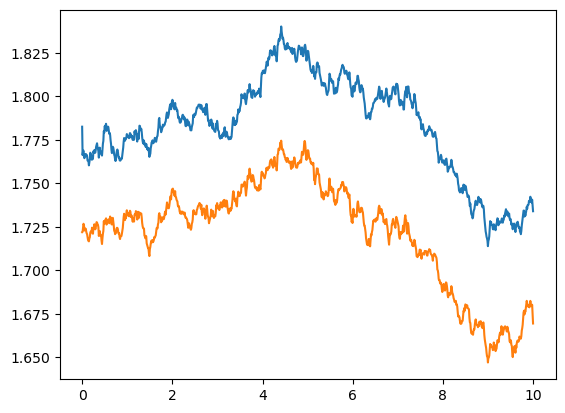

In [70]:
timestamps = np.linspace(0,10,1000) #time in hours
t, target_star_pwv, target_star_phase, target_star_mean = power_spectrum(12000, 1, 24000, timestamps, mean = 2)
t1, comparison_star_pwv, _, _ = power_spectrum(12000, 1, 24000, timestamps, mean = target_star_mean, target = False, phase = target_star_phase, separation = 25)

plt.plot(t, target_star_pwv)
plt.plot(t, comparison_star_pwv)
plt.show()


In [71]:
def photon_noise(flux, bin_size, mirror_diameter = 1, exp_time = 60, throughput = .4):
    
    mirror_area = np.pi*((mirror_diameter/2)**2) - np.pi*((.25)**2)
    #print("mirror area:"+str(mirror_area))
    
    #bin_size_array = [bin_array[1]-bin_array[0]]
    '''
    i=0
    for n in bin_array:
        if i == len(bin_array)-1:
            break
        bin_size2 = bin_array[i+1] - bin_array[i]
        bin_size_array.append(bin_size2)
        j+=1
    '''
    num_photons = flux*mirror_area*exp_time*throughput*bin_size
    print("num photons:"+str(num_photons))
    noise_std_dev = 1/(num_photons**(1/2))
    print("noise std dev:"+str(noise_std_dev))
    
    photon_noise_gaussian = np.random.normal(1, noise_std_dev, len(flux))
    
    return photon_noise_gaussian

In [72]:
'''
function that takes in stellar spectrum, wave range, and res. Output is timeseries of flux based on pwv variability,
one timeseries for each wavelength. 
'''


def binned_flux_pwv_v2(spectrum, pwv_input, wave_in, wave_out, res):
    stellar = spec_wave_range(spectrum, wave_in, wave_out)
    stellar_wave = stellar[0]
    stellar_flux = stellar[1]
    #pwv = np.load("pwv_target.npy")
    
    
    transmission_array = []
    
    i=0
    for n in stellar_wave:
        str_value = str(stellar_wave[i])
        value = stellar_wave[i]/10
        stellar_flux_value = stellar_flux[i]
        transmission  = interpolate_water(pwv_input, value)
        flux = stellar_flux_value*transmission
        d[str_value+"_trans_array"] = np.array(flux)
    
        transmission_array.append(d[str_value+"_trans_array"])
        i+=1
        
    transmission_array = np.array(transmission_array)
    
    time_array = np.arange(0, len(pwv_input), 1)
    
    transmission_array_binned = []
    #wave_in_converted = wave_in*1000
    #wave_out_converted = wave_out*1000
    wave_in_converted = wave_in*100
    wave_out_converted = wave_out*100
    
    print(stellar_wave)
    j=0
    for n in time_array:
        
        bin_1 = res_bin_timestamp(transmission_array[:,j], stellar_wave, res, wave_in_converted, wave_out_converted)
        transmission_array_binned.append(bin_1)
        j+=1
    
    return(transmission_array_binned)

In [73]:
'''
tweaked binning function that allows binning at every point in the pwv timeseries
'''

def res_bin_timestamp(flux, wavelength, res, wave_in, wave_fin, spectrum_type="stellar"):
    #print(wavelength)
    #print
    print(flux)
    wave_in = wavelength[0]
    wave_fin = wavelength[-1]
    wave_array = [wave_in]
    n=wave_array[0]
    i=0
    #print(wave_in)
    #print(wave_fin)
    while wave_in <= n <= wave_fin:
        if wave_array[i] >= wave_fin:
            break
        bin_size = wave_array[i]/res
        if wave_array[i]+bin_size >= wave_fin:
            break
        wave_array.append(wave_array[i]+bin_size)
        n=wave_array[i]
        i+=1
    #print(wave_array)
    
    
        
    if spectrum_type == "stellar":
        
        wave_in_index = 0
        wave_out_index = -1
        
        '''
        use this section if using binning function individually and need to specify wave range
        wave_in_index = np.where(wavelength == wave_in*10)[0]
        print(wave_in_index)
        wave_out_index = np.where(wavelength == wave_fin*10)[0]
        print(wave_out_index)
        '''

        wavelength_range = wavelength[wave_in_index:wave_out_index]
        #print(wavelength_range)
        #finds step size of stellar spectrum
        
        high_res_step = [wavelength_range[1]-wavelength_range[0]]
        j=0
        for n in wavelength:
            if j == len(wavelength_range)-1:
                break
            bin_size2 = wavelength_range[j+1] - wavelength_range[j]
            high_res_step.append(bin_size2)
            j+=1
        
        #flux must be multiplied by fractional step size in order to scale it for binning
        #flux = (spectrum.flux.value)*high_res_step
        flux_new = (flux[wave_in_index:wave_out_index])*high_res_step
        #print(high_res_step)
        #print(len(flux_new))
        #print(len(wavelength_range))
        print(len(flux_new))
        
        
    elif spectrum_type == "earth":
        wavelength = spectrum["col1"]
        flux = spectrum["col2"]
    
    #plt.hist(wavelength_range, bins=wave_array, weights=flux_new)
    #plt.show()
    return np.histogram(wavelength_range, bins=wave_array, weights=flux_new)


In [75]:
import batman

params = batman.TransitParams()       #object to store transit parameters
params.t0 = 0.                        #time of inferior conjunction
params.per = 1.                       #orbital period 
params.rp = .07                       #planet radi`us (in units of stellar radii)
params.a = 15.                        #semi-major axis (in units of stellar radii)
params.inc = 87.                      #orbital inclination (in degrees)
params.ecc = 0.                       #eccentricity
params.w = 90.                        #longitude of periastron (in degrees)
params.limb_dark = "nonlinear"        #limb darkening model
params.u = [0.5, 0.1, 0.1, -0.1]      #limb darkening coefficients [u1, u2, u3, u4]

t = np.linspace(-0.025, 0.025, 1000)  #times at which to calculate light curve
model = batman.TransitModel(params, t)    #initializes model

In [76]:
transit = model.light_curve(params)
#plt.plot(transit)

#transit

In [77]:
planet_atm_abs4 = ascii.read("planet_atm_spec_1.65-2.1.dat")
depth_atm_wave_abs4 = planet_atm_abs4["col1"]
depth_atm_abs4 = planet_atm_abs4["col6"]

planet_atm_abs3 = ascii.read("planet_atm_spec_1.25-1.56.dat")
depth_atm_wave_abs3 = planet_atm_abs3["col1"]
depth_atm_abs3 = planet_atm_abs3["col6"]

planet_atm_abs2 = ascii.read("planet_atm_spec_.85-1.dat")
depth_atm_wave_abs2 = planet_atm_abs2["col1"]
depth_atm_abs2 = planet_atm_abs2["col6"]

planet_atm_abs1 = ascii.read("planet_atm_spec_1-1.2.dat")
depth_atm_wave_abs1 = planet_atm_abs1["col1"]
depth_atm_abs1 = planet_atm_abs1["col6"]
#depth_atm

In [79]:
def division_noise_transit(target_array, ref_array, atm):
    new_array1 = []
    bin_size_array = [target_array[1][1]-target_array[1][0]]
    
    t = np.linspace(-0.025, 0.025, 1000)
    bulk_transit_depth = params.rp**2
    #new_array2
    i=0
    for n in target_array[0][0]:
        if i >= len(atm["col6"]):
            break
        
        bin_size = target_array[1][i+1]-target_array[1][i]
        bin_size_array.append(bin_size)
        target_array_i = np.array(target_array[0][:,i])
        #print("original target array"+str(target_array_i[0:10]))
        
        #adding transit
        atm_transit_i = atm["col6"][i]/10**6
        #print("atm depth"+str(atm_transit_i))
        
        total_transit_depth = bulk_transit_depth + atm_transit_i
        rp_i = np.sqrt(total_transit_depth)
        params.rp = rp_i
        #print("rp"+str(params.rp))
        model = batman.TransitModel(params, t)
        transit = model.light_curve(params)
        #print("transit model"+str(transit[500:510]))
        
        #flux = stellar_flux_value*transmission
        transit_flux = transit*target_array_i
        #print("flux with transit"+str(transit_flux[0:10]))
        
        
        ref_array_i = np.array(ref_array[0][:,i])
        target_noise = photon_noise(transit_flux, bin_size)
        ref_noise = photon_noise(ref_array_i, bin_size)
        noisy_target_i = target_noise*transit_flux
        noisy_ref_i = ref_noise*ref_array_i
        divided_i = noisy_target_i/noisy_ref_i
        new_array1.append(divided_i)
        i+=1
        #if i == 3:
            #break
    return new_array1

#cold_star_abs1_test3[:,0]


In [80]:
def diff_spec_v2_pt1_transit(target_temp, ref_temp, mag1, mag2):
    target_spec = spectrum(target_temp, mag1)
    ref_spec = spectrum(ref_temp, mag2)
    return target_spec, ref_spec

def diff_spec_v2_pt2_transit(target_spec, ref_spec, target_pwv, ref_pwv, wave_in, wave_out, atm, res=200, exp_time = 3600, throughput = .4):
    target_binned = binned_flux_pwv_v2(target_spec, target_pwv, wave_in, wave_out, res)
    #wave_array = target_binned_all[1]
    ref_binned = binned_flux_pwv_v2(ref_spec, ref_pwv, wave_in, wave_out, res)
    target_stacked = stacking(target_binned)
    ref_stacked = stacking(ref_binned)
    diff = division_noise_transit(target_stacked, ref_stacked, atm)
    return diff

def diff_spec_v2_pt3_transit(diff):
    normalized_array = []
    i=0
    for n in diff:
        diff_mean = np.mean(diff[i])
        normalized = (diff[i]-diff_mean)/diff_mean
        normalized_array.append(normalized)
        i+=1    
    return normalized_array

In [83]:
target_spec, ref_spec = diff_spec_v2_pt1_transit(4000, 5000, 2, 3)
diff2 = diff_spec_v2_pt2_transit(target_spec, ref_spec, target_star_pwv, comparison_star_pwv, 1.65, 2.1, planet_atm_abs4)
diff_spec = diff_spec_v2_pt3_transit(diff2)

[[2429.5809798  2374.45864975 2372.14193551 ... 1400.8870171
  1670.91656731 1734.93582552]
 [2429.60703191 2374.48295262 2372.15750222 ... 1400.9554053
  1670.99915469 1734.98987879]
 [2429.60360582 2374.47975657 2372.15545506 ... 1400.94641164
  1670.98829371 1734.9827703 ]
 ...
 [2429.64788399 2374.52106173 2372.18191225 ... 1401.06264426
  1671.12865929 1735.07463929]
 [2429.65261961 2374.52547938 2372.18474189 ... 1401.07507552
  1671.1436716  1735.08446482]
 [2429.6584581  2374.53092585 2372.18823051 ... 1401.09040187
  1671.16218011 1735.0965786 ]]
[[768.75972975 755.82629    760.07270765 ... 423.26398486 504.00574158
  524.76883766]
 [768.75962155 755.82618802 760.07264234 ... 423.26371025 504.00541452
  524.76861818]
 [768.75836312 755.82500187 760.07188265 ... 423.26051636 504.00161049
  524.76606551]
 ...
 [768.78059532 755.84595692 760.08530373 ... 423.31694145 504.06881457
  524.81116242]
 [768.78365014 755.84883626 760.08714786 ... 423.32469456 504.07804877
  524.81735898

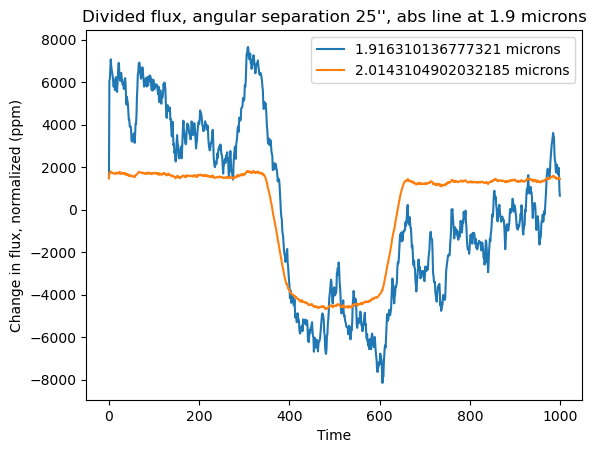

In [106]:
wave_range_abs4 = bin_array(1.65, 2.1, 200)

#plt.plot(diff_spec[0]*10**6, label=str(wave_range[0])+" microns")
#plt.plot(diff_spec[10]*10**6, label=str(wave_range[10])+" microns")
#plt.plot(diff_spec[15]*10**6, label=str(wave_range[15])+" microns")
#plt.plot(diff_spec[17]*10**6, label=str(wave_range[17])+" microns")
#plt.plot(diff_spec[18]*10**6, label=str(wave_range[18])+" microns")
#plt.plot(diff_spec[20]*10**6, label=str(wave_range_abs4[20])+" microns")
plt.plot(diff_spec[30]*10**6, label=str(wave_range_abs4[30])+" microns")
plt.plot(diff_spec[40]*10**6, label=str(wave_range_abs4[40])+" microns")
#plt.plot(diff_spec[40])
#plt.plot(diff_spec[47])

plt.title("Divided flux, angular separation 25'', abs line at 1.9 microns")

plt.xlabel("Time")
plt.ylabel("Change in flux, normalized (ppm)")
plt.legend()

In [85]:
target_spec_abs2, ref_spec_abs2 = diff_spec_v2_pt1_transit(4000, 6000, 5, 7)
diff_abs2 = diff_spec_v2_pt2_transit(target_spec_abs2, ref_spec_abs2, target_star_pwv, comparison_star_pwv, 1, 1.2, planet_atm_abs2)
diff_spec_abs2 = diff_spec_v2_pt3_transit(diff_abs2)

[[ 95.43590115  94.99648682  96.67580277 ... 107.11311419 108.40397208
  111.08611632]
 [ 95.43692461  94.99748319  96.67636702 ... 107.14086909 108.4279661
  111.10180777]
 [ 95.43679001  94.99735216  96.67629281 ... 107.13721907 108.42481067
  111.09974421]
 ...
 [ 95.43852948  94.99904559  96.67725181 ... 107.1843913  108.46559093
  111.12641341]
 [ 95.43871552  94.9992267   96.67735438 ... 107.18943645 108.46995245
  111.12926572]
 [ 95.43894489  94.99945     96.67748083 ... 107.19565654 108.4753297
  111.13278231]]
[[19.13690252 18.81144966 19.28731837 ... 17.86106788 17.96876085
  18.38125801]
 [19.13689976 18.81144708 19.2873169  ... 17.86100673 17.96870792
  18.38122378]
 [19.13686763 18.81141701 19.2872998  ... 17.86029545 17.96809227
  18.38082556]
 ...
 [19.13743529 18.81194814 19.28760185 ... 17.87286128 17.97896858
  18.38786059]
 [19.13751329 18.81202112 19.28764335 ... 17.87458789 17.98046304
  18.38882724]
 [19.13757318 18.81207715 19.28767522 ... 17.8759135  17.9816104

1.1048955771867306


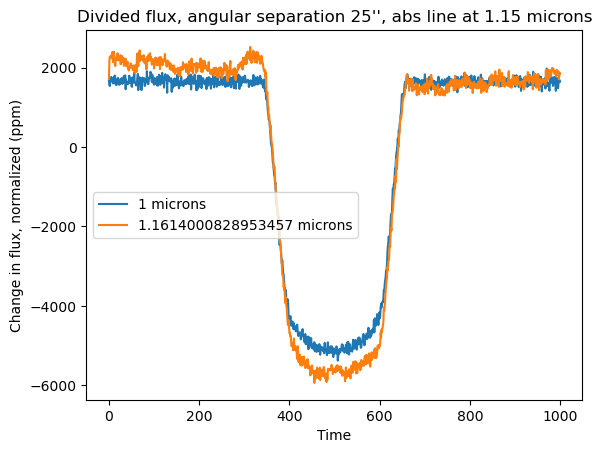

In [108]:
wave_range_abs2 = bin_array(1, 1.2, 200)

#plt.plot(diff_spec[0]*10**6, label=str(wave_range[0])+" microns")
#plt.plot(diff_spec[10]*10**6, label=str(wave_range[10])+" microns")
#plt.plot(diff_spec[15]*10**6, label=str(wave_range[15])+" microns")
#plt.plot(diff_spec[17]*10**6, label=str(wave_range[17])+" microns")
#plt.plot(diff_spec[18]*10**6, label=str(wave_range[18])+" microns")
plt.plot(diff_spec_abs2[0]*10**6, label=str(wave_range_abs2[0])+" microns")
#plt.plot(diff_spec_abs2[10]*10**6, label=str(wave_range_abs2[10])+" microns")
#plt.plot(diff_spec_abs2[20]*10**6, label=str(wave_range_abs2[20])+" microns")
plt.plot(diff_spec_abs2[30]*10**6, label=str(wave_range_abs2[30])+" microns")
#plt.plot(diff_spec_abs2[32]*10**6, label=str(wave_range_abs2[32])+" microns")
#plt.plot(diff_spec[30]*10**6, label=str(wave_range[30])+" microns")
#plt.plot(diff_spec_abs2[20]*10**6, label=str(wave_range_abs2[20])+" microns")
#plt.plot(diff_spec_abs2[30]*10**6, label=str(wave_range_abs2[30])+" microns")
#plt.plot(diff_spec_abs2[35]*10**6, label=str(wave_range_abs2[35])+" microns")
#plt.plot(diff_spec[40])
#plt.plot(diff_spec[47])
#ax = plt.gca()
#ax.set_xlim(400,600)
#ax.set_ylim(-7500, -4000)
plt.legend()

plt.xlabel("Time")
plt.ylabel("Change in flux, normalized (ppm)")

plt.title("Divided flux, angular separation 25'', abs line at 1.15 microns")

print(wave_range_abs2[20])

In [87]:
target_spec_abs3, ref_spec_abs3 = diff_spec_v2_pt1_transit(5000, 6000, 8, 10)
diff_abs3 = diff_spec_v2_pt2_transit(target_spec_abs3, ref_spec_abs3, target_star_pwv, comparison_star_pwv, 1.25, 1.56, planet_atm_abs3)
diff_spec_abs3 = diff_spec_v2_pt3_transit(diff_abs3)

[[7.14706678 6.95203791 6.39610474 ... 7.7549231  7.93831407 7.85401734]
 [7.14707318 6.95203984 6.39611725 ... 7.75507693 7.93843668 7.85407515]
 [7.14707234 6.95203959 6.3961156  ... 7.7550567  7.93842056 7.85406754]
 ...
 [7.14708322 6.95204288 6.39613687 ... 7.75531816 7.93862894 7.85416579]
 [7.14708439 6.95204323 6.39613914 ... 7.75534612 7.93865123 7.8541763 ]
 [7.14708582 6.95204366 6.39614195 ... 7.7553806  7.93867871 7.85418926]]
[[1.12459233 1.08508865 1.00025989 ... 1.05345868 1.06573192 1.0579545 ]
 [1.12459232 1.08508864 1.00025986 ... 1.0534584  1.0657317  1.0579544 ]
 [1.12459216 1.0850886  1.00025956 ... 1.05345518 1.06572917 1.05795319]
 ...
 [1.12459489 1.08508942 1.00026492 ... 1.05351207 1.06577395 1.05797443]
 [1.12459527 1.08508954 1.00026565 ... 1.05351989 1.06578011 1.05797735]
 [1.12459556 1.08508963 1.00026622 ... 1.05352589 1.06578483 1.05797959]]


In [118]:
len(diff_abs3)

44

Text(0.5, 1.0, "Divided flux, angular separation 25'', abs line at 1.3 microns")

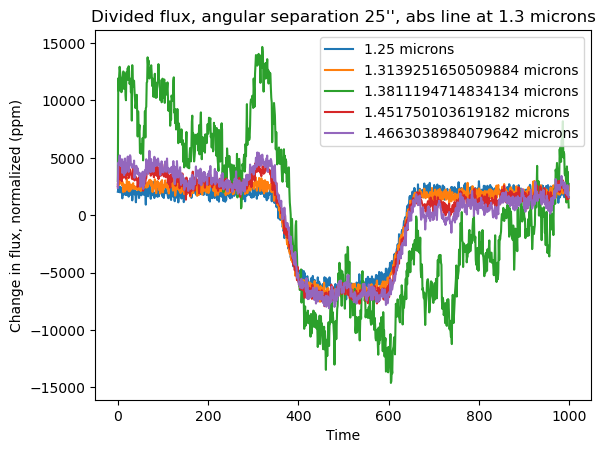

In [96]:
wave_range_abs3 = bin_array(1.25, 1.56, 200)

#plt.plot(diff_spec[0]*10**6, label=str(wave_range[0])+" microns")
#plt.plot(diff_spec[10]*10**6, label=str(wave_range[10])+" microns")
#plt.plot(diff_spec[15]*10**6, label=str(wave_range[15])+" microns")
#plt.plot(diff_spec[17]*10**6, label=str(wave_range[17])+" microns")
#plt.plot(diff_spec[18]*10**6, label=str(wave_range[18])+" microns")
plt.plot(diff_spec_abs3[0]*10**6, label=str(wave_range_abs3[0])+" microns")
plt.plot(diff_spec_abs3[10]*10**6, label=str(wave_range_abs3[10])+" microns")
plt.plot(diff_spec_abs3[20]*10**6, label=str(wave_range_abs3[20])+" microns")
plt.plot(diff_spec_abs3[30]*10**6, label=str(wave_range_abs3[30])+" microns")
plt.plot(diff_spec_abs3[32]*10**6, label=str(wave_range_abs3[32])+" microns")
#plt.plot(diff_spec[30]*10**6, label=str(wave_range[30])+" microns")
#plt.plot(diff_spec_abs2[20]*10**6, label=str(wave_range_abs2[20])+" microns")
#plt.plot(diff_spec_abs2[30]*10**6, label=str(wave_range_abs2[30])+" microns")
#plt.plot(diff_spec_abs2[35]*10**6, label=str(wave_range_abs2[35])+" microns")
#plt.plot(diff_spec[40])
#plt.plot(diff_spec[47])
#ax = plt.gca()
#ax.set_xlim(400,600)
#ax.set_ylim(-7500, -4000)
plt.legend()

plt.xlabel("Time")
plt.ylabel("Change in flux, normalized (ppm)")

plt.title("Divided flux, angular separation 25'', abs line at 1.3 microns")

#print(wave_range_abs2[20])

In [124]:
def no_division_noise_transit(target_array, ref_array, atm):
    target_array_transit = []
    ref_array_notransit = []
    bin_size_array = [target_array[1][1]-target_array[1][0]]
    
    t = np.linspace(-0.025, 0.025, 1000)
    bulk_transit_depth = params.rp**2
    #new_array2
    i=0
    for n in target_array[0][0]:
        if i >= len(atm["col6"]):
            break
        
        bin_size = target_array[1][i+1]-target_array[1][i]
        bin_size_array.append(bin_size)
        target_array_i = np.array(target_array[0][:,i])
        #print("original target array"+str(target_array_i[0:10]))
        
        #adding transit
        atm_transit_i = atm["col6"][i]/10**6
        #print("atm depth"+str(atm_transit_i))
        
        total_transit_depth = bulk_transit_depth + atm_transit_i
        rp_i = np.sqrt(total_transit_depth)
        params.rp = rp_i
        #print("rp"+str(params.rp))
        model = batman.TransitModel(params, t)
        transit = model.light_curve(params)
        #print("transit model"+str(transit[500:510]))
        
        #flux = stellar_flux_value*transmission
        transit_flux = transit*target_array_i
        #print("flux with transit"+str(transit_flux[0:10]))
        
        
        ref_array_i = np.array(ref_array[0][:,i])
        target_noise = photon_noise(transit_flux, bin_size)
        ref_noise = photon_noise(ref_array_i, bin_size)
        noisy_target_i = target_noise*transit_flux
        noisy_ref_i = ref_noise*ref_array_i
        #divided_i = noisy_target_i/noisy_ref_i
        #new_array1.append(divided_i)
        target_array_transit.append(noisy_target_i)
        ref_array_notransit.append(noisy_ref_i)
        i+=1
        #if i == 3:
            #break
    return target_array_transit, ref_array_notransit

#cold_star_abs1_test3[:,0]


In [202]:
def diff_spec_v2_pt1_transit_nodiv(target_temp, ref_temp, mag1, mag2):
    target_spec = spectrum(target_temp, mag1)
    ref_spec = spectrum(ref_temp, mag2)
    return target_spec, ref_spec

def diff_spec_v2_pt2_transit_nodiv(target_spec, ref_spec, target_pwv, ref_pwv, wave_in, wave_out, atm, res=200, exp_time = 3600, throughput = .4):
    target_binned = binned_flux_pwv_v2(target_spec, target_pwv, wave_in, wave_out, res)
    #wave_array = target_binned_all[1]
    ref_binned = binned_flux_pwv_v2(ref_spec, ref_pwv, wave_in, wave_out, res)
    target_stacked = stacking(target_binned)
    ref_stacked = stacking(ref_binned)
    diff = no_division_noise_transit(target_stacked, ref_stacked, atm)
    return diff

def diff_spec_v2_pt3_transit_nodiv(diff):
    normalized_array = []
    i=0
    for n in diff:
        diff_mean = np.mean(diff[i])
        normalized = ((diff[i])/diff_mean)-1
        normalized_array.append(normalized)
        i+=1    
    return normalized_array
    

In [203]:
target_spec_abs3_nodiv, ref_spec_abs3_nodiv = diff_spec_v2_pt1_transit(5000, 6000, 8, 10)
why_not_divided = diff_spec_v2_pt2_transit_nodiv(target_spec_abs3_nodiv, ref_spec_abs3_nodiv, target_star_pwv, comparison_star_pwv, 1.25, 1.56, planet_atm_abs3)
diff_spec_abs3_nodiv = diff_spec_v2_pt3_transit_nodiv(diff_abs3_nodiv)

[[7.14700537 6.95201935 6.39598474 ... 7.75344769 7.93713817 7.85346293]
 [7.14701493 6.95202224 6.39600341 ... 7.75367727 7.93732114 7.8535492 ]
 [7.14701501 6.95202226 6.39600356 ... 7.75367913 7.93732262 7.85354989]
 ...
 [7.14698995 6.95201469 6.39595459 ... 7.75307698 7.93684271 7.85332362]
 [7.1469895  6.95201455 6.39595371 ... 7.75306617 7.93683409 7.85331956]
 [7.14698922 6.95201447 6.39595316 ... 7.7530595  7.93682877 7.85331705]]
[[1.12458042 1.08508504 1.00023652 ... 1.05321065 1.06553665 1.05786191]
 [1.12458156 1.08508538 1.00023875 ... 1.05323433 1.06555529 1.05787075]
 [1.12458159 1.08508539 1.00023881 ... 1.05323497 1.06555579 1.05787099]
 ...
 [1.12457803 1.08508431 1.00023184 ... 1.05316099 1.06549755 1.05784338]
 [1.12457795 1.08508429 1.00023167 ... 1.05315922 1.06549616 1.05784272]
 [1.12457792 1.08508428 1.00023162 ... 1.0531587  1.06549575 1.05784252]]


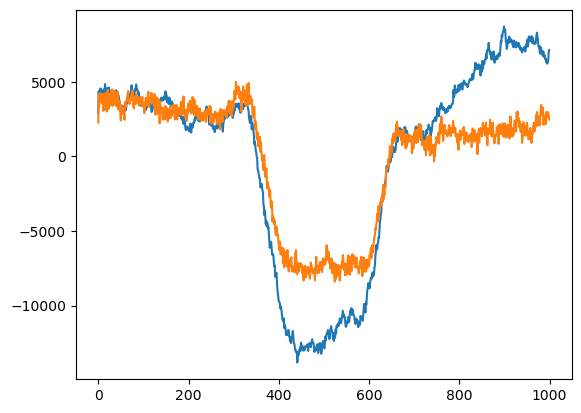

In [148]:
#plt.plot(why_not_divided[4])
#len(why_not_divided)
abs_normalized = why_not_divided[0][30]/np.mean(why_not_divided[0][30])
#len(why_not_divided[0])
plt.plot((abs_normalized-1)*10**6)
plt.plot(diff_spec_abs3_nodiv[30]*10**6, label=str(wave_range_abs3_nodiv[30])+" microns")

'\nsomething weird is going on here, it still looks divided.\n'

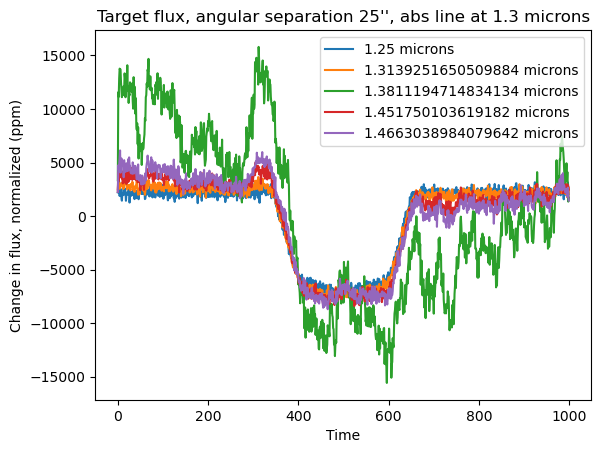

In [190]:
wave_range_abs3_nodiv = bin_array(1.25, 1.56, 200)

#plt.plot(diff_spec[0]*10**6, label=str(wave_range[0])+" microns")
#plt.plot(diff_spec[10]*10**6, label=str(wave_range[10])+" microns")
#plt.plot(diff_spec[15]*10**6, label=str(wave_range[15])+" microns")
#plt.plot(diff_spec[17]*10**6, label=str(wave_range[17])+" microns")
#plt.plot(diff_spec[18]*10**6, label=str(wave_range[18])+" microns")
plt.plot(diff_spec_abs3_nodiv[0]*10**6, label=str(wave_range_abs3_nodiv[0])+" microns")
plt.plot(diff_spec_abs3_nodiv[10]*10**6, label=str(wave_range_abs3_nodiv[10])+" microns")
plt.plot(diff_spec_abs3_nodiv[20]*10**6, label=str(wave_range_abs3_nodiv[20])+" microns")
plt.plot(diff_spec_abs3_nodiv[30]*10**6, label=str(wave_range_abs3_nodiv[30])+" microns")
plt.plot(diff_spec_abs3_nodiv[32]*10**6, label=str(wave_range_abs3_nodiv[32])+" microns")
#plt.plot(diff_spec[30]*10**6, label=str(wave_range[30])+" microns")
#plt.plot(diff_spec_abs2[20]*10**6, label=str(wave_range_abs2[20])+" microns")
#plt.plot(diff_spec_abs2[30]*10**6, label=str(wave_range_abs2[30])+" microns")
#plt.plot(diff_spec_abs2[35]*10**6, label=str(wave_range_abs2[35])+" microns")
#plt.plot(diff_spec[40])
#plt.plot(diff_spec[47])
#ax = plt.gca()
#ax.set_xlim(400,600)
#ax.set_ylim(-7500, -4000)
plt.legend()

plt.xlabel("Time")
plt.ylabel("Change in flux, normalized (ppm)")

plt.title("Target flux, angular separation 25'', abs line at 1.3 microns")

'''
something weird is going on here, it still looks divided.
'''

#print(wave_range_abs2[20])

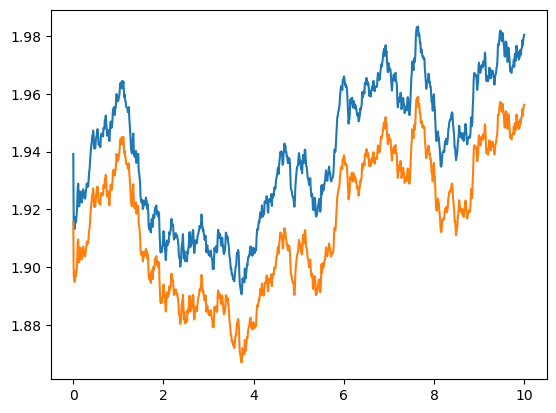

In [154]:
timestamps = np.linspace(0,10,1000) #time in hours
t, target_star_pwv, target_star_phase, target_star_mean = power_spectrum(12000, 1, 24000, timestamps, mean = 2)
t1, comparison_star_pwv, _, _ = power_spectrum(12000, 1, 24000, timestamps, mean = target_star_mean, target = False, phase = target_star_phase, separation = 5)

plt.plot(t, target_star_pwv)
plt.plot(t, comparison_star_pwv)
plt.show()


In [155]:
target_spec_close, ref_spec_close = diff_spec_v2_pt1_transit(5000, 6000, 8, 10)
close2 = diff_spec_v2_pt2_transit_nodiv(target_spec_close, ref_spec_close, target_star_pwv, comparison_star_pwv, 1.25, 1.56, planet_atm_abs3)
close3 = diff_spec_v2_pt3_transit_nodiv(close2)

[[7.14700537 6.95201935 6.39598474 ... 7.75344769 7.93713817 7.85346293]
 [7.14701493 6.95202224 6.39600341 ... 7.75367727 7.93732114 7.8535492 ]
 [7.14701501 6.95202226 6.39600356 ... 7.75367913 7.93732262 7.85354989]
 ...
 [7.14698995 6.95201469 6.39595459 ... 7.75307698 7.93684271 7.85332362]
 [7.1469895  6.95201455 6.39595371 ... 7.75306617 7.93683409 7.85331956]
 [7.14698922 6.95201447 6.39595316 ... 7.7530595  7.93682877 7.85331705]]
[[1.12458042 1.08508504 1.00023652 ... 1.05321065 1.06553665 1.05786191]
 [1.12458156 1.08508538 1.00023875 ... 1.05323433 1.06555529 1.05787075]
 [1.12458159 1.08508539 1.00023881 ... 1.05323497 1.06555579 1.05787099]
 ...
 [1.12457803 1.08508431 1.00023184 ... 1.05316099 1.06549755 1.05784338]
 [1.12457795 1.08508429 1.00023167 ... 1.05315922 1.06549616 1.05784272]
 [1.12457792 1.08508428 1.00023162 ... 1.0531587  1.06549575 1.05784252]]


In [204]:
close2_div = diff_spec_v2_pt2_transit(target_spec_close, ref_spec_close, target_star_pwv, comparison_star_pwv, 1.25, 1.56, planet_atm_abs3)
close3_div = diff_spec_v2_pt3_transit(close2_div)

[[7.14700537 6.95201935 6.39598474 ... 7.75344769 7.93713817 7.85346293]
 [7.14701493 6.95202224 6.39600341 ... 7.75367727 7.93732114 7.8535492 ]
 [7.14701501 6.95202226 6.39600356 ... 7.75367913 7.93732262 7.85354989]
 ...
 [7.14698995 6.95201469 6.39595459 ... 7.75307698 7.93684271 7.85332362]
 [7.1469895  6.95201455 6.39595371 ... 7.75306617 7.93683409 7.85331956]
 [7.14698922 6.95201447 6.39595316 ... 7.7530595  7.93682877 7.85331705]]
[[1.12458042 1.08508504 1.00023652 ... 1.05321065 1.06553665 1.05786191]
 [1.12458156 1.08508538 1.00023875 ... 1.05323433 1.06555529 1.05787075]
 [1.12458159 1.08508539 1.00023881 ... 1.05323497 1.06555579 1.05787099]
 ...
 [1.12457803 1.08508431 1.00023184 ... 1.05316099 1.06549755 1.05784338]
 [1.12457795 1.08508429 1.00023167 ... 1.05315922 1.06549616 1.05784272]
 [1.12457792 1.08508428 1.00023162 ... 1.0531587  1.06549575 1.05784252]]


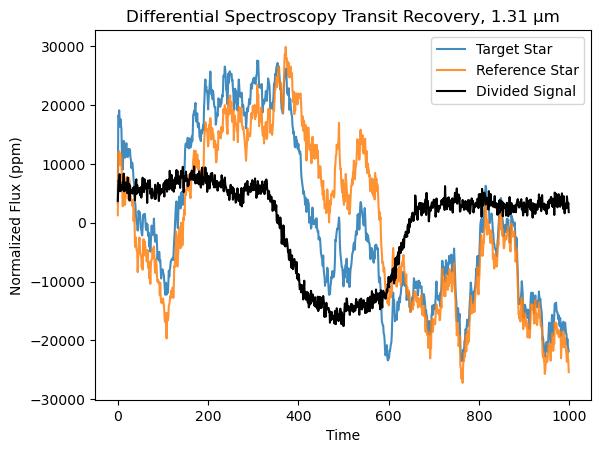

In [207]:
#plt.plot(why_not_divided[4])
#len(why_not_divided)
abs_normalized2 = close2[0][20]/np.mean(close2[0][20])
ref_normalized2 = close2[1][20]/np.mean(close2[1][20])
#len(why_not_divided[0])
plt.plot((abs_normalized2-1)*10**6, label="Target Star", alpha=.85)
plt.plot((ref_normalized2-1)*10**6, label="Reference Star", alpha=.85)
plt.plot(close3_div[20]*10**6, label="Divided Signal", color = "black")

#1.381 microns

plt.title("Differential Spectroscopy Transit Recovery, 1.31 μm")
plt.ylabel("Normalized Flux (ppm)")
plt.xlabel("Time")
plt.legend()

plt.savefig("Diff_Spec.pdf")

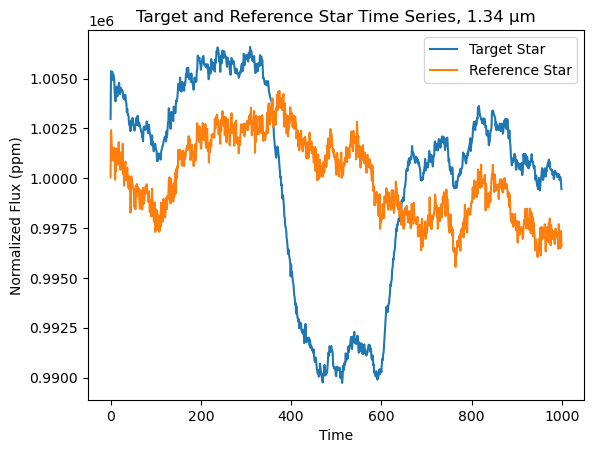

In [211]:
abs_normalized2 = close2[0][14]/np.mean(close2[0][14])
ref_normalized2 = close2[1][14]/np.mean(close2[1][14])

plt.plot((abs_normalized2)*10**6, label="Target Star")
plt.plot((ref_normalized2)*10**6, label="Reference Star")

plt.legend()

plt.xlabel("Time")
plt.ylabel("Normalized Flux (ppm)")
plt.title("Target and Reference Star Time Series, 1.34 μm")
plt.savefig("Transit_1.34_microns.pdf")
plt.show()


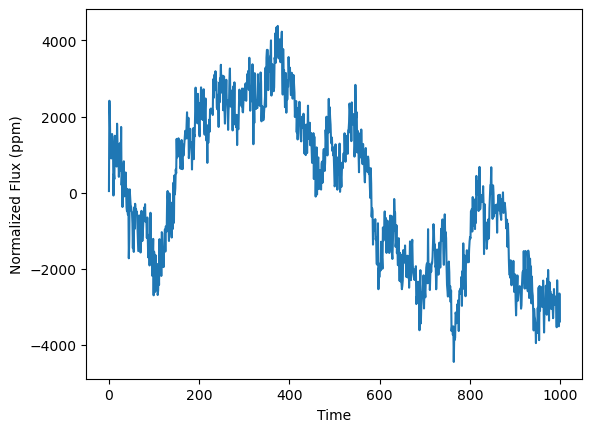

In [210]:
plt.plot((ref_normalized2-1)*10**6, label="Reference Star")

plt.xlabel("Time")
plt.ylabel("Normalized Flux (ppm)")
plt.savefig("Ref_1.34_microns.png")

In [ ]:
abs_normalized2 = close2[0][14]/np.mean(close2[0][14])